In [1]:
import sys, os
import matplotlib.pyplot as plt
import requests
import json
import pandas as pd
from pandas.io import sql
from pandas.io.json import json_normalize
import numpy as np
from sqlalchemy import types, create_engine
from datetime import date, timedelta
from datetime import datetime
import time
import re
import pylab as py
from matplotlib import gridspec
import matplotlib.dates as md
from sklearn.model_selection import LeaveOneOut
os.environ['PROJ_LIB'] = '/home/ehsan/anaconda3/share/proj'
import matplotlib
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
def metrics(y1, y2):
  '''
  y1 and y2 are two series of the same size

  This function outputs the MAE, RMSE and R^2 
  of the cross evaluated series.

  '''
  y1 = y1.reshape(-1)
  y2 = y2.reshape(-1)
  RMSE = np.sqrt(np.mean((y1-y2)**2))
  MAE = np.mean(np.abs(y1-y2))
  R2 = r2_score(y1, y2)
  print('MAE: %.2f'%MAE, ' RMSE: %.2f'%RMSE, ' R^2: %.2f'%R2)
########################################

In [3]:
df = pd.read_csv("Tmin_Data_Not_Filled.txt", encoding = "ISO-8859-1", engine='python')

In [4]:
meta_columns = ['SKN', 'Station.Name', 'Sta..ID', 'Island', 'Network', 'LON', 'LAT', 'Elev.']
Temp_columns = df.columns[8:]
Temp_columns

Index(['X1990.01.01', 'X1990.01.02', 'X1990.01.03', 'X1990.01.04',
       'X1990.01.05', 'X1990.01.06', 'X1990.01.07', 'X1990.01.08',
       'X1990.01.09', 'X1990.01.10',
       ...
       'X2014.12.22', 'X2014.12.23', 'X2014.12.24', 'X2014.12.25',
       'X2014.12.26', 'X2014.12.27', 'X2014.12.28', 'X2014.12.29',
       'X2014.12.30', 'X2014.12.31'],
      dtype='object', length=9131)

In [5]:
df2 = df[meta_columns]
df2 = df2.set_index("SKN")

print(len(df2))

df2.head()

142


,Station.Name,Sta..ID,Island,Network,LON,LAT,Elev.
SKN,,,,,,,
337.2,Puu o Pele,CN1,Ma,CraterNet,-156.212261,20.718443,2281.0
337.3,Lava lake,CN2,Ma,CraterNet,-156.188007,20.717807,2258.0
337.6,Puu Nole,CN3,Ma,CraterNet,-156.224485,20.709651,2430.0
337.4,Silversword loop,CN4,Ma,CraterNet,-156.205387,20.731704,2185.0
337.0,south rim,CN5,Ma,CraterNet,-156.239400,20.714563,2704.0


In [6]:
df2.groupby("Island").count()

,Station.Name,Sta..ID,Network,LON,LAT,Elev.
Island,,,,,,
BI,32,32,32,32,32,32
Bi,19,19,19,19,19,19
Ka,14,14,14,14,14,14
Ko,5,5,5,5,5,5
La,2,2,2,2,2,2
Ma,31,31,31,31,31,31
Mo,6,6,6,6,6,6
Oa,33,33,33,33,33,33


In [7]:
# df2 = df2[(df2.Island=='BI')|(df2.Island=='Bi')]
df2 = df2[(df2.Island=='Ma')]
print(len(df2))

df2.head()

31


,Station.Name,Sta..ID,Island,Network,LON,LAT,Elev.
SKN,,,,,,,
337.2,Puu o Pele,CN1,Ma,CraterNet,-156.212261,20.718443,2281.0
337.3,Lava lake,CN2,Ma,CraterNet,-156.188007,20.717807,2258.0
337.6,Puu Nole,CN3,Ma,CraterNet,-156.224485,20.709651,2430.0
337.4,Silversword loop,CN4,Ma,CraterNet,-156.205387,20.731704,2185.0
337.0,south rim,CN5,Ma,CraterNet,-156.239400,20.714563,2704.0


In [8]:
df1 = df[["SKN"]+list(Temp_columns)].T

new_header = df1.iloc[0]
df1 = df1[1:] 
df1.columns = new_header 

df1.index = pd.to_datetime([x.split('X')[1] for x in df1.index.values])
df1.index.name = 'Date'

df1 = df1[list(df2.index.values)]

# df1 = df1.resample('1M').mean()

print(len(df1))
df1.tail(5)

9131


SKN,337.2,337.3,337.6,337.4,337.0,337.1,328.4,324.6,253.0,339.4,...,278.3,355.0,446.0,324.7,267.0,361.0,249.1,258.6,457.1,398.0
Date,,,,,,,,,,,,,,,,,,,,,
2014-12-27,NaN,5.257,6.382,5.205,NaN,2.637,NaN,NaN,11.285,4.6685,...,NaN,16.1,NaN,NaN,NaN,NaN,17.8,NaN,NaN,NaN
2014-12-28,NaN,5.745,6.535,1.778,NaN,7.469,NaN,NaN,11.320,9.4300,...,NaN,19.4,NaN,NaN,7.8,NaN,15.6,NaN,NaN,NaN
2014-12-29,NaN,7.544,3.958,5.462,NaN,5.770,NaN,NaN,11.400,8.9050,...,NaN,17.8,NaN,NaN,7.8,NaN,16.7,NaN,16.1,NaN
2014-12-30,NaN,4.844,5.024,3.380,NaN,1.832,NaN,NaN,11.435,5.6215,...,NaN,17.8,NaN,NaN,8.9,NaN,18.3,NaN,16.7,NaN
2014-12-31,NaN,5.898,6.712,8.693,NaN,2.956,NaN,NaN,10.795,5.2025,...,NaN,17.8,NaN,NaN,8.9,NaN,18.9,NaN,NaN,NaN


In [9]:
df3 = df2[["LON", "LAT", "Elev."]].T
df3 = df3[list(df2.index.values)]
df3

SKN,337.2,337.3,337.6,337.4,337.0,337.1,328.4,324.6,253.0,339.4,...,278.3,355.0,446.0,324.7,267.0,361.0,249.1,258.6,457.1,398.0
LON,-156.212261,-156.188007,-156.224485,-156.205387,-156.239400,-156.241101,-156.277500,-156.320028,-156.342056,-156.248167,...,-156.12140,-156.0157,-156.212,-156.3211,-156.356,-156.6742,-156.4400,-156.042,-156.6736,-156.435
LAT,20.718443,20.717807,20.709651,20.731704,20.714563,20.703948,20.757639,20.757889,20.644222,20.759806,...,20.73506,20.7946,20.890,20.7583,20.700,20.8789,20.6419,20.663,20.9286,20.889
Elev.,2281.000000,2258.000000,2430.000000,2185.000000,2704.000000,2911.000000,1645.000000,965.000000,1168.000000,2120.000000,...,2143.00000,19.0000,213.000,944.9000,916.000,11.6000,26.8000,24.000,128.3000,12.000


<ipython-input-10-1c922e9583bb>:4: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  map = Basemap(llcrnrlon=-160.5,llcrnrlat=18.5,urcrnrlon=-154.5,urcrnrlat=22.5, projection='cyl')
<ipython-input-10-1c922e9583bb>:6: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  shp_info = map.readshapefile('st99_d00','states',drawbounds=True,
<ipython-input-10-1c922e9583bb>:8: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  shp_info_ = map.readshapefile('st99_d00','states',drawbounds=False)


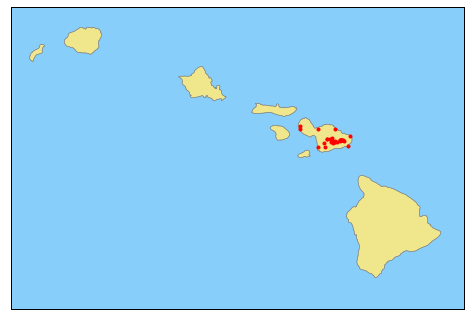

In [10]:
fig=plt.figure(figsize=(7,7))
ax = fig.add_axes([0.05,0.05,0.9,0.9])

map = Basemap(llcrnrlon=-160.5,llcrnrlat=18.5,urcrnrlon=-154.5,urcrnrlat=22.5, projection='cyl')

shp_info = map.readshapefile('st99_d00','states',drawbounds=True,
                           linewidth=0.45,color='gray')
shp_info_ = map.readshapefile('st99_d00','states',drawbounds=False)


map.drawmapboundary(fill_color='lightskyblue')

for lon, lat in list(zip(df2.LON.values, df2.LAT.values)):
    
    x, y = map(lon, lat)
    map.plot(x, y, marker='o',color='red',markersize=3)

for nshape, shapedict in enumerate(map.states_info):
     if shapedict['NAME'] in ['Hawaii']:
         seg = map.states[int(shapedict['SHAPENUM'] - 1)]
         poly = Polygon(seg, facecolor='khaki', edgecolor='gray', linewidth=.45)
         ax.add_patch(poly)

# ax.annotate("Oahu",(-158.27,21.8), fontsize=12)
# ax.annotate("Maui",(-156.28,20.98), fontsize=12)
# ax.annotate("Hawaii",(-155.8,19.54), fontsize=12)
# ax.annotate("Molokai",(-157.23,21.31), fontsize=12)
# ax.annotate("Kauai",(-159.7,21.7), fontsize=12)
# ax.annotate("Lanai",(-157.55,20.74), fontsize=12)

# ax.annotate("HAWAII",(-160.24,18.75), fontsize=16)

In [11]:
df_station =  df3.T
df_station = df_station.join(df1.T, how='left')

print(len(df_station))

df_station.head()

31


,LON,LAT,Elev.,1990-01-01 00:00:00,1990-01-02 00:00:00,1990-01-03 00:00:00,1990-01-04 00:00:00,1990-01-05 00:00:00,1990-01-06 00:00:00,1990-01-07 00:00:00,...,2014-12-22 00:00:00,2014-12-23 00:00:00,2014-12-24 00:00:00,2014-12-25 00:00:00,2014-12-26 00:00:00,2014-12-27 00:00:00,2014-12-28 00:00:00,2014-12-29 00:00:00,2014-12-30 00:00:00,2014-12-31 00:00:00
SKN,,,,,,,,,,,,,,,,,,,,,
337.2,-156.212261,20.718443,2281.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
337.3,-156.188007,20.717807,2258.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.454,5.334,4.584,4.636,6.535,5.257,5.745,7.544,4.844,5.898
337.6,-156.224485,20.709651,2430.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.298,4.298,2.877,5.437,9.312,6.382,6.535,3.958,5.024,6.712
337.4,-156.205387,20.731704,2185.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.584,6.255,4.402,2.047,4.246,5.205,1.778,5.462,3.380,8.693
337.0,-156.239400,20.714563,2704.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
Date = pd.to_datetime("2005-10-15")

data = df_station[["LON", "LAT", "Elev.", Date]].dropna()

print(len(data))

data.head()

11


,LON,LAT,Elev.,2005-10-15 00:00:00
SKN,,,,
324.6,-156.320028,20.757889,965.0,13.650
253.0,-156.342056,20.644222,1168.0,14.210
339.4,-156.248167,20.759806,2120.0,5.343
339.5,-156.245833,20.738194,2590.0,6.886
339.6,-156.256750,20.710361,2990.0,6.018


In [13]:
X = data[["LON", "LAT", "Elev."]].values

y = data[Date].values

In [16]:
from getMap_matrix import *
fname = r'./geoTiffs_250m/rf/bi_meanAnn_250m.tif'
X_grid = getmap(fname)

In [14]:
from scipy.optimize import minimize
import george
from george import kernels
from sklearn.model_selection import KFold

[-6.02879131e-03  1.90224196e+01  2.74135991e-04]
MAE: 0.94  RMSE: 1.29  R^2: 0.94


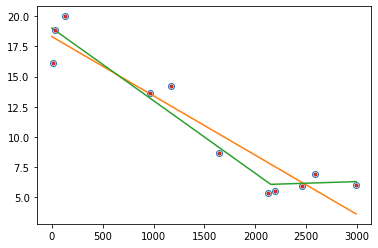

In [15]:
from scipy.optimize import curve_fit

def linear(x, a, b):
    return a*x+b

def bilinear(x, a, b, c):
    
    left  = a*x+b
    right = c*(x-2150) + (a*2150+b) 
    
    try:
        y = np.asarray([left[i] if x[i]<=2150 else right[i] for i in range(len(x))])
        return y
    except:
        if x<=2150:
            return left
        else:
            return right

plt.plot(X[:,2], y, 'o', mfc='white')




u = np.arange(np.round(np.max(X[:,2])))

fit, cov = curve_fit(linear, X[:,2], y, sigma=y*0+1)
v1 = linear(u, fit[0], fit[1])

fit, cov = curve_fit(bilinear, X[:,2], y, sigma=y*0+1)



model = bilinear(X[:,2], fit[0], fit[1], fit[2])

indx, = np.where(np.abs(model-y)<3)

fit, cov = curve_fit(bilinear, X[:,2][indx], y[indx], sigma=y[indx]*0+1)


model = bilinear(X[:,2], fit[0], fit[1], fit[2])

indx, = np.where(np.abs(model-y)<4)

fit, cov = curve_fit(bilinear, X[:,2][indx], y[indx], sigma=y[indx]*0+1)

plt.plot(u, v1)

v2 = bilinear(u, fit[0], fit[1], fit[2])
plt.plot(u, v2)

plt.plot(X[:,2][indx], y[indx], '.')

print(fit)

metrics(bilinear(X[:,2][indx], fit[0], fit[1], fit[2]), y[indx])

In [16]:
def esnModel(theta, X_train, X_test, y_train, y_test, Hinv=2150):
    
        zp = theta[0]
        slope = theta[1]
        l1 = np.exp(theta[2])
        l2 = np.exp(theta[3])
        sigma = np.exp(theta[4])
        s2 = theta[5]
        err = np.exp(theta[6])

        y_model = slope*X_train[:,2]+zp
        ind, = np.where(X_train[:,2]>Hinv)
        y_model[ind] += s2*(X_train[:,2][ind]-Hinv)

        kernel = sigma * kernels.ExpSquaredKernel([l1 , l2], ndim=2)
        gp = george.GP(kernel)
        gp.compute(X_train[:,:2], err)

        y_res_test, _ = gp.predict(y_train-y_model, X_test[:,:2], return_var=True)

        y_model_test = slope*X_test[:,2]+zp
        ind, = np.where(X_test[:,2]>Hinv)
        y_model_test[ind] += s2*(X_test[:,2][ind]-Hinv)    
        
        
        return y_res_test+y_model_test

In [17]:
def nll_fn2(X, y):
    def step(theta):
        loo = LeaveOneOut()
        XI2 = 0
        for train_index, test_index in loo.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
        
            model_out = esnModel(theta, X_train, X_test, y_train, y_test)
            XI2 += np.sum((model_out - y_test)**2)
        return XI2
    return step


iter = 0
T0 = 0.
output = []
while iter<5:
    
    try:
        # Maximum Likelihood
        res = minimize(nll_fn2(X[indx], y[indx]), [T0, -0.001, 1, 1, 0.1, -0.001, -1], method='SLSQP', 
                      bounds=((0,50), (-0.1, 0), 
                              (None, 10), (None,10), (None, 20),
                              (-0.0001, 0), (-10,1)))

        theta = res.x
        loo = LeaveOneOut()

        X_ = X[indx]
        y_ = y[indx]

        u = []
        v = []

        for train_index, test_index in loo.split(X_):
            X_train, X_test = X_[train_index], X_[test_index]
            y_train, y_test = y_[train_index], y_[test_index]

            model_out = esnModel(theta, X_train, X_test, y_train, y_test)  

            u.append(model_out[0])
            v.append(y_test[0])
        R2 = r2_score(np.asarray(u), np.asarray(v))

        output.append([R2, theta])
        
        T0 = np.random.uniform(0, 50)
        print(iter, T0, '%.3f'%R2)
        iter+=1
    except:
        T0 = np.random.uniform(0, 50)
        print(iter, T0)
        continue
    

0 17.066870343988853 0.961
1 44.598486530818946 0.964
2 25.487629707945388 0.959
3 19.273363914040235 0.954
4 10.133901321296628
4 38.64799485695359 0.976


In [23]:
res

     fun: 7.628681698126156
     jac: array([ 2.35438347e-05, -1.21848464e-01,  6.48915768e-04, -9.62913036e-04,
       -1.29401684e-04, -1.75594242e+02,  2.70187855e-04])
 message: 'Optimization terminated successfully.'
    nfev: 437
     nit: 46
    njev: 45
  status: 0
 success: True
       x: array([ 2.16307360e+01, -5.18962726e-03, -2.29348940e+00, -4.72750228e+00,
        1.08623821e+00,  0.00000000e+00, -1.85876270e+00])

In [18]:
output.sort(key= lambda x: x[0], reverse=True)

theta = output[0][1]
R2 = output[0][0]

print(theta, R2)

[ 2.16307360e+01 -5.18962726e-03 -2.29348940e+00 -4.72750228e+00
  1.08623821e+00  0.00000000e+00 -1.85876270e+00] 0.9764007673438779


In [19]:
# %%time
# from skopt import gp_minimize

# res = gp_minimize(nll_fn2(X[indx], y[indx]),                  # the function to minimize
#                   [(0.,50.), (-0.1, -0.0001), 
#                       (0., 10.), (0.,10.), 
#                       (-0.0001, 0.01), (-10.,1.)],      # the bounds on each dimension of x
#                   acq_func="gp_hedge",      # the acquisition function
#                   n_calls=200,         # the number of evaluations of f
#                   n_random_starts=30,  # the number of random initialization points
#                   random_state=30)   # the random seed

# print(res.x)

In [20]:
# from skopt.plots import plot_convergence
# plot_convergence(res);

Text(0, 0.5, 'Temperature [oC]')

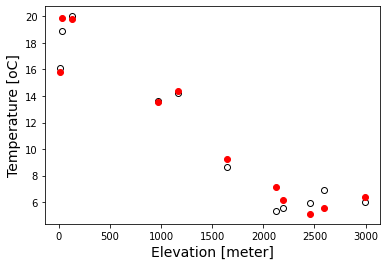

In [21]:
plt.plot(df3.iloc[2].values, df1.loc[Date].values, 'ko', mfc='none')

loo = LeaveOneOut()

X_ = X[indx]
y_ = y[indx]

u = []
v = []

for train_index, test_index in loo.split(X_):
    X_train, X_test = X_[train_index], X_[test_index]
    y_train, y_test = y_[train_index], y_[test_index]


    model_out = esnModel(theta, X_train, X_test, y_train, y_test)  
    
    plt.plot(X_test[:,2], model_out, 'ro')   
    u.append(model_out[0])
    v.append(y_test[0])
    
    
u = np.asarray(u)
v = np.asarray(v)

plt.xlabel("Elevation [meter]", fontsize=14)
plt.ylabel("Temperature [oC]", fontsize=14)

MAE: 0.66  RMSE: 0.83  R^2: 0.98


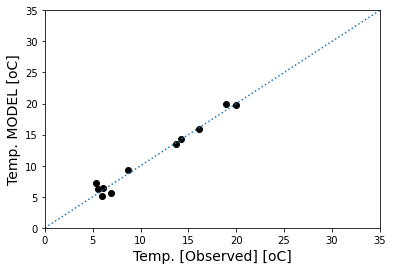

In [22]:
plt.plot(v, u, 'ko')

plt.xlim(0,35)
plt.ylim(0,35)

plt.plot([0,35], [0,35], ':')

plt.ylabel("Temp. MODEL [oC]", fontsize=14)
plt.xlabel("Temp. [Observed] [oC]", fontsize=14)

metrics(u, v)